In [43]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf


from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
from moviepy.editor import *

Imageio: 'ffmpeg-win32-v3.2.4.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-win32-v3.2.4.exe (34.1 MB)
Downloading: 8192/35749888 bytes (0.049152/35749888 bytes (0.1%90112/35749888 bytes (0.3%139264/35749888 bytes (0.4188416/35749888 bytes (0.5237568/35749888 bytes (0.7278528/35749888 bytes (0.8327680/35749888 bytes (0.9376832/35749888 bytes (1.1425984/35749888 bytes (1.2475136/35749888 bytes (1.3524288/35749888 bytes (1.5573440/35749888 bytes (1.6614400/35749888 bytes (1.7663552/35749888 bytes (1.9704512/35749888 bytes (2.0753664/35749888 bytes (2.1794624/35749888 bytes (2.2843776/35749888 bytes (2.4892928/35749888 bytes (2.5942080/35749888 bytes (2.6991232/35749888 bytes (2.81040384/35749888 bytes (2.9%1089536/35749888 bytes (3.0%1138688/35749888 bytes (3.2%1187840/35749888 bytes (3.3%1236992/35749888 bytes (3.5%1286144/35749888 bytes (3.6%1335296/35749888 bytes (3.7%1384448/35749888 

In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

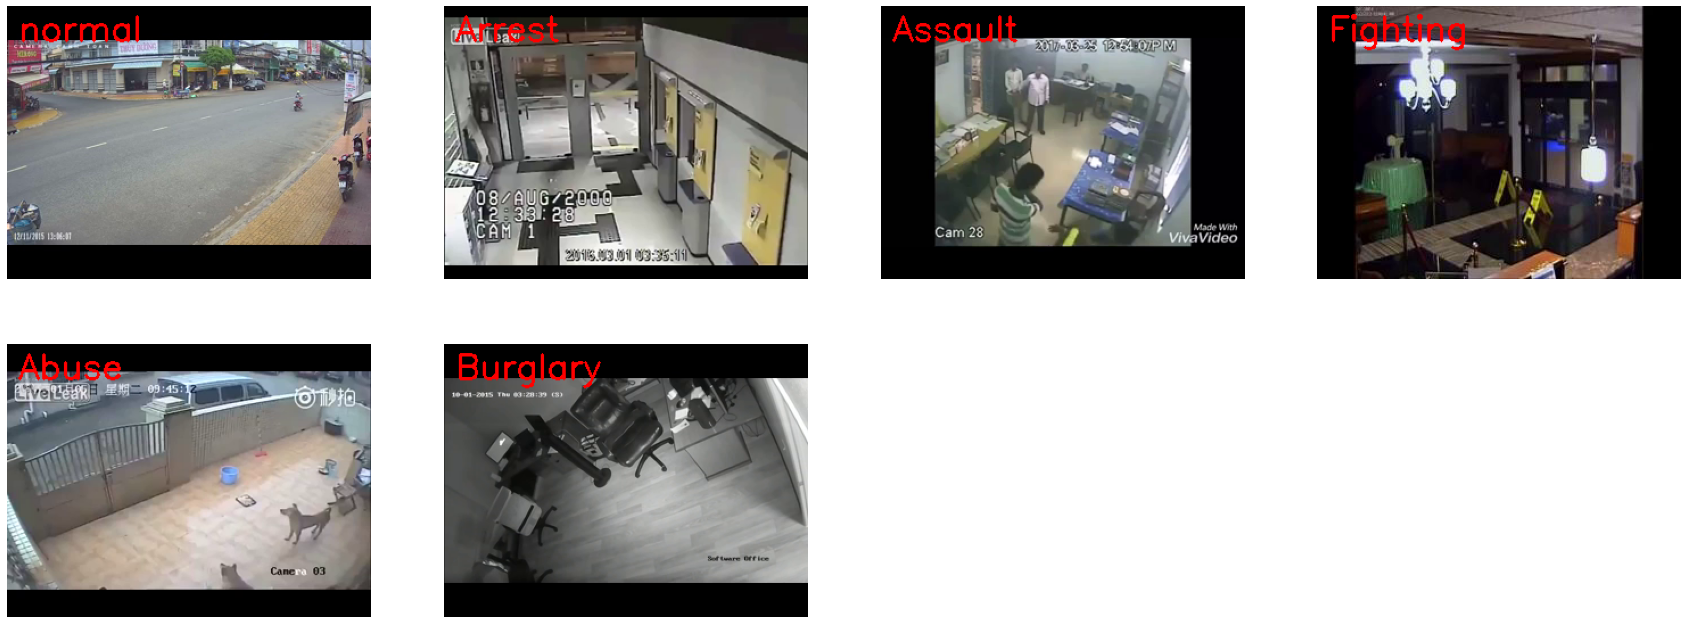

In [14]:
plt.figure(figsize= (30,30))
all_classes_names = os.listdir('dataset')
random_range = random.sample(range(len(all_classes_names)), 6)
for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'dataset/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'dataset/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [16]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "dataset"
classes_list = ["normal", "Assault", "Burglary", "Fighting"]

model_output_size = len(classes_list)

In [17]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [18]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [19]:
features, labels = create_dataset()

Extracting Data of Class: normal
Extracting Data of Class: Assault
Extracting Data of Class: Burglary
Extracting Data of Class: Fighting


In [20]:
one_hot_encoded_labels = to_categorical(labels)

In [21]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)


In [22]:
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

In [32]:

import graphviz


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [34]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 5, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/5
5120/5120 [==============================] - 254s 49ms/step - loss: 0.2822 - accuracy: 0.8992 - val_loss: 1.1435 - val_accuracy: 0.7098
Epoch 2/5
5120/5120 [==============================] - 247s 48ms/step - loss: 0.1289 - accuracy: 0.9585 - val_loss: 0.0698 - val_accuracy: 0.9953
Epoch 3/5
5120/5120 [==============================] - 248s 48ms/step - loss: 0.0972 - accuracy: 0.9695 - val_loss: 0.0884 - val_accuracy: 0.9988
Epoch 4/5
5120/5120 [==============================] - 248s 48ms/step - loss: 0.0748 - accuracy: 0.9778 - val_loss: 0.1852 - val_accuracy: 0.9635
Epoch 5/5
5120/5120 [==============================] - 261s 51ms/step - loss: 0.0737 - accuracy: 0.9785 - val_loss: 0.0409 - val_accuracy: 0.9984


In [35]:
model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 10s 47ms/step - loss: 0.0434 - accuracy: 0.9980


In [36]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

In [37]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

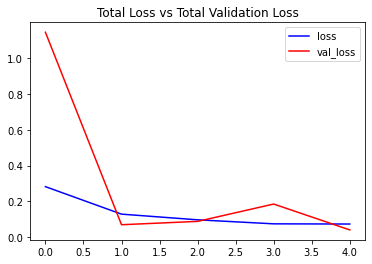

In [38]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [39]:
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)

    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()

    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'

    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)

    # Returning Video Title
    return video.title

In [55]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [58]:
video_title = '1'

In [59]:
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [71]:

window_size = 25


output_video_file_path = f'{output_directory}/{video_title}.mp4'


predict_on_live_video(input_video_file_path, output_video_file_path, window_size)


VideoFileClip(output_video_file_path).ipython_display(width = 700)

100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


In [67]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        try: 
            resized_frame = cv2.resize(frame, (image_height, image_width))
        except Exception as e:
            print(str(e))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()

In [68]:
# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\s

100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
